Agenda

1. Data Loading & Basic Exploratory Analysis
2. Feature Engineering
3. Machine Learning

    3.1. Scoring Metrics

    3.2. Cross Validation

    3.3. Parameter Grid Search
    
    3.4. Feature Importance
4. Tasks
5. Ideas

In [1]:
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Install libraries with: `pip install requirements.txt`

#### 1. Data Loading & Basic Exploratory Analysis

In [2]:
df_bookings = pd.read_csv("./data.csv", sep=";", header=0)

In [3]:
df_bookings.shape

(44, 14)

In [4]:
df_bookings.head()

hotel_id datum_dolaska datum_kreiranja_rezervacije datum_odjave  \
0         0      1.7.2015                   21.1.2015     1.7.2015   
1         0      1.7.2015                   10.6.2015     1.7.2015   
2         0      1.7.2015                   13.5.2015     2.7.2015   
3         0      1.7.2015                   30.5.2014     2.7.2015   
4         0      1.7.2015                    6.7.2014     3.7.2015   

  datum_otkazivanja_rezervacije  broj_odraslih_gostiju  broj_djece_gostiju  \
0                           NaN                      2                   0   
1                           NaN                      2                   0   
2                           NaN                      1                   0   
3                           NaN                      1                   3   
4                           NaN                      2                   0   

  zemlja_gosta  kanal_prodaje_id  tip_sobe_id cijena_nocenja  \
0          PRT                 2            0            100   
1          PRT                 1            0            127   
2          GBR                 0            1    66,99134525   
3          GBR                 1            1    74,36889708   
4          GBR                 1            1     23,9732783   

  status_rezervacije  rezervacija_id  gost_id  
0          Check-Out         1313223  1077152  
1          Check-Out         1313224  1017906  
2          Check-Out         1313225  1039896  
3          Check-Out         1313226  1008245  
4          Check-Out         1313227  1093703

In [5]:
df_bookings.describe()

hotel_id  broj_odraslih_gostiju  broj_djece_gostiju  kanal_prodaje_id  \
count  44.000000              44.000000           44.000000         44.000000   
mean    0.500000               1.636364            0.545455          1.068182   
std     0.505781               0.685087            0.847830          0.899554   
min     0.000000               0.000000            0.000000          0.000000   
25%     0.000000               1.000000            0.000000          0.000000   
50%     0.500000               2.000000            0.000000          1.000000   
75%     1.000000               2.000000            1.000000          2.000000   
max     1.000000               4.000000            3.000000          2.000000   

       tip_sobe_id  rezervacija_id       gost_id  
count    44.000000    4.400000e+01  4.400000e+01  
mean      0.909091    1.313244e+06  1.550623e+06  
std       0.910359    1.284523e+01  5.067514e+05  
min       0.000000    1.313223e+06  1.008245e+06  
25%       0.000000    1.313234e+06  1.044264e+06  
50%       1.000000    1.313244e+06  1.554902e+06  
75%       1.000000    1.313255e+06  2.044263e+06  
max       3.000000    1.313266e+06  2.101558e+06

In [6]:
df_bookings.hotel_id.unique()

array([0, 1], dtype=int64)

Food for thought: try splitting the dataset for each hotel.

In [7]:
df_bookings.kanal_prodaje_id.unique()

array([2, 1, 0], dtype=int64)

In [8]:
df_bookings.tip_sobe_id.unique()

array([0, 1, 2, 3], dtype=int64)

In [9]:
df_bookings.zemlja_gosta.unique()

array(['PRT', 'GBR'], dtype=object)

In [10]:
df_bookings.status_rezervacije.unique()

array(['Check-Out', 'Canceled'], dtype=object)

In [11]:
df_bookings.isnull().sum()

hotel_id                          0
datum_dolaska                     0
datum_kreiranja_rezervacije       0
datum_odjave                      0
datum_otkazivanja_rezervacije    32
broj_odraslih_gostiju             0
broj_djece_gostiju                0
zemlja_gosta                      0
kanal_prodaje_id                  0
tip_sobe_id                       0
cijena_nocenja                    0
status_rezervacije                0
rezervacija_id                    0
gost_id                           0
dtype: int64

Handling missing values:

https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values

https://www.geeksforgeeks.org/ml-handling-missing-values/

#### 2. Feature Engineering

In [12]:
df_bookings['datum_dolaska'] = pd.to_datetime(df_bookings['datum_dolaska'], format='%d.%m.%Y')
df_bookings['datum_kreiranja_rezervacije'] = pd.to_datetime(df_bookings['datum_kreiranja_rezervacije'], format='%d.%m.%Y')
df_bookings['datum_odjave'] = pd.to_datetime(df_bookings['datum_odjave'], format='%d.%m.%Y')
df_bookings['datum_otkazivanja_rezervacije'] = pd.to_datetime(df_bookings['datum_otkazivanja_rezervacije'], format='%d.%m.%Y')

df_bookings['datum_dolaska_y'] = df_bookings['datum_dolaska'].apply(lambda x: x.year)
df_bookings['datum_dolaska_m'] = df_bookings['datum_dolaska'].apply(lambda x: x.month)
df_bookings['datum_dolaska_d'] = df_bookings['datum_dolaska'].apply(lambda x: x.day)

df_bookings['datum_kreiranja_rezervacije_y'] = df_bookings['datum_kreiranja_rezervacije'].apply(lambda x: x.year)
df_bookings['datum_kreiranja_rezervacije_m'] = df_bookings['datum_kreiranja_rezervacije'].apply(lambda x: x.month)
df_bookings['datum_kreiranja_rezervacije_d'] = df_bookings['datum_kreiranja_rezervacije'].apply(lambda x: x.day)

df_bookings['cijena_nocenja'] = df_bookings['cijena_nocenja'].apply(lambda x: float(x.replace(',', '.')))

In [13]:
# this will be our variable to predict (label)
df_bookings['trajanje_dolaska'] = (df_bookings['datum_odjave'] - df_bookings['datum_dolaska']).dt.days
df_bookings['trajanje_dolaska'] = df_bookings['trajanje_dolaska'].apply(lambda x: 1 if x < 0 else x + 1)

In [14]:
df_bookings.head()

hotel_id datum_dolaska datum_kreiranja_rezervacije datum_odjave  \
0         0    2015-07-01                  2015-01-21   2015-07-01   
1         0    2015-07-01                  2015-06-10   2015-07-01   
2         0    2015-07-01                  2015-05-13   2015-07-02   
3         0    2015-07-01                  2014-05-30   2015-07-02   
4         0    2015-07-01                  2014-07-06   2015-07-03   

  datum_otkazivanja_rezervacije  broj_odraslih_gostiju  broj_djece_gostiju  \
0                           NaT                      2                   0   
1                           NaT                      2                   0   
2                           NaT                      1                   0   
3                           NaT                      1                   3   
4                           NaT                      2                   0   

  zemlja_gosta  kanal_prodaje_id  tip_sobe_id  ...  status_rezervacije  \
0          PRT                 2            0  ...           Check-Out   
1          PRT                 1            0  ...           Check-Out   
2          GBR                 0            1  ...           Check-Out   
3          GBR                 1            1  ...           Check-Out   
4          GBR                 1            1  ...           Check-Out   

  rezervacija_id  gost_id  datum_dolaska_y  datum_dolaska_m  datum_dolaska_d  \
0        1313223  1077152             2015                7                1   
1        1313224  1017906             2015                7                1   
2        1313225  1039896             2015                7                1   
3        1313226  1008245             2015                7                1   
4        1313227  1093703             2015                7                1   

   datum_kreiranja_rezervacije_y  datum_kreiranja_rezervacije_m  \
0                           2015                              1   
1                           2015                              6   
2                           2015                              5   
3                           2014                              5   
4                           2014                              7   

   datum_kreiranja_rezervacije_d  trajanje_dolaska  
0                             21                 1  
1                             10                 1  
2                             13                 2  
3                             30                 2  
4                              6                 3  

[5 rows x 21 columns]

Questions:

1. Why remove 'rezervacija_id' attribute?

https://h2o.ai/wiki/target-leakage/

https://machinelearningmastery.com/data-leakage-machine-learning/

2. Check if 'datum_dolaska' is greater than 'datum_odjave'. What to do with those rows? E.g. remove them?

In [15]:
df_bookings.drop(["datum_dolaska", "datum_kreiranja_rezervacije", "datum_odjave", "datum_otkazivanja_rezervacije", "rezervacija_id"], axis=1, inplace=True)

In [16]:
df_bookings.head()

hotel_id  broj_odraslih_gostiju  broj_djece_gostiju zemlja_gosta  \
0         0                      2                   0          PRT   
1         0                      2                   0          PRT   
2         0                      1                   0          GBR   
3         0                      1                   3          GBR   
4         0                      2                   0          GBR   

   kanal_prodaje_id  tip_sobe_id  cijena_nocenja status_rezervacije  gost_id  \
0                 2            0      100.000000          Check-Out  1077152   
1                 1            0      127.000000          Check-Out  1017906   
2                 0            1       66.991345          Check-Out  1039896   
3                 1            1       74.368897          Check-Out  1008245   
4                 1            1       23.973278          Check-Out  1093703   

   datum_dolaska_y  datum_dolaska_m  datum_dolaska_d  \
0             2015                7                1   
1             2015                7                1   
2             2015                7                1   
3             2015                7                1   
4             2015                7                1   

   datum_kreiranja_rezervacije_y  datum_kreiranja_rezervacije_m  \
0                           2015                              1   
1                           2015                              6   
2                           2015                              5   
3                           2014                              5   
4                           2014                              7   

   datum_kreiranja_rezervacije_d  trajanje_dolaska  
0                             21                 1  
1                             10                 1  
2                             13                 2  
3                             30                 2  
4                              6                 3

Let's filter only Checked-Out bookings

In [17]:
df_bookings = df_bookings[df_bookings["status_rezervacije"] == "Check-Out"]

df_bookings.status_rezervacije.unique()

array(['Check-Out'], dtype=object)

In [18]:
df_bookings.drop(["status_rezervacije"], axis=1, inplace=True)
df_bookings.shape

(32, 15)

Some of the variables are not numerical...

https://medium.com/machine-learning-concepts/data-pre-processing-edfc1eecd0c2
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder

In [19]:
le = LabelEncoder()
df_bookings['zemlja_gosta'] = le.fit_transform(df_bookings['zemlja_gosta'])

In [20]:
df_bookings.head()

hotel_id  broj_odraslih_gostiju  broj_djece_gostiju  zemlja_gosta  \
0         0                      2                   0             1   
1         0                      2                   0             1   
2         0                      1                   0             0   
3         0                      1                   3             0   
4         0                      2                   0             0   

   kanal_prodaje_id  tip_sobe_id  cijena_nocenja  gost_id  datum_dolaska_y  \
0                 2            0      100.000000  1077152             2015   
1                 1            0      127.000000  1017906             2015   
2                 0            1       66.991345  1039896             2015   
3                 1            1       74.368897  1008245             2015   
4                 1            1       23.973278  1093703             2015   

   datum_dolaska_m  datum_dolaska_d  datum_kreiranja_rezervacije_y  \
0                7                1                           2015   
1                7                1                           2015   
2                7                1                           2015   
3                7                1                           2014   
4                7                1                           2014   

   datum_kreiranja_rezervacije_m  datum_kreiranja_rezervacije_d  \
0                              1                             21   
1                              6                             10   
2                              5                             13   
3                              5                             30   
4                              7                              6   

   trajanje_dolaska  
0                 1  
1                 1  
2                 2  
3                 2  
4                 3

In [21]:
df_bookings.describe()

hotel_id  broj_odraslih_gostiju  broj_djece_gostiju  zemlja_gosta  \
count  32.000000              32.000000           32.000000     32.000000   
mean    0.500000               1.750000            0.562500      0.500000   
std     0.508001               0.672022            0.913607      0.508001   
min     0.000000               1.000000            0.000000      0.000000   
25%     0.000000               1.000000            0.000000      0.000000   
50%     0.500000               2.000000            0.000000      0.500000   
75%     1.000000               2.000000            1.000000      1.000000   
max     1.000000               4.000000            3.000000      1.000000   

       kanal_prodaje_id  tip_sobe_id  cijena_nocenja       gost_id  \
count         32.000000    32.000000       32.000000  3.200000e+01   
mean           0.718750     0.500000      125.539680  1.550623e+06   
std            0.812578     0.508001       96.585995  5.091397e+05   
min            0.000000     0.000000       23.973278  1.008245e+06   
25%            0.000000     0.000000       72.524509  1.043172e+06   
50%            0.500000     0.500000      100.000000  1.554902e+06   
75%            1.000000     1.000000      151.176542  2.040988e+06   
max            2.000000     1.000000      554.000000  2.101558e+06   

       datum_dolaska_y  datum_dolaska_m  datum_dolaska_d  \
count             32.0             32.0        32.000000   
mean            2015.0              7.0         1.562500   
std                0.0              0.0         0.618922   
min             2015.0              7.0         1.000000   
25%             2015.0              7.0         1.000000   
50%             2015.0              7.0         1.500000   
75%             2015.0              7.0         2.000000   
max             2015.0              7.0         3.000000   

       datum_kreiranja_rezervacije_y  datum_kreiranja_rezervacije_m  \
count                      32.000000                      32.000000   
mean                     2014.625000                       5.406250   
std                         0.491869                       2.255593   
min                      2014.000000                       1.000000   
25%                      2014.000000                       4.000000   
50%                      2015.000000                       5.500000   
75%                      2015.000000                       6.250000   
max                      2015.000000                      11.000000   

       datum_kreiranja_rezervacije_d  trajanje_dolaska  
count                      32.000000         32.000000  
mean                       17.843750          2.031250  
std                         7.401436          0.739851  
min                         6.000000          1.000000  
25%                        12.750000          1.750000  
50%                        18.500000          2.000000  
75%                        22.000000          3.000000  
max                        30.000000          3.000000

In [22]:
# move label column to the last position
temp_cols = df_bookings.columns.tolist()
index = df_bookings.columns.get_loc("trajanje_dolaska")
new_cols = temp_cols[0:index] + temp_cols[index+1:] + temp_cols[index:index+1] 
df_bookings = df_bookings[new_cols]

variables_nr = len(df_bookings.columns)

In [23]:
df_bookings.head()

hotel_id  broj_odraslih_gostiju  broj_djece_gostiju  zemlja_gosta  \
0         0                      2                   0             1   
1         0                      2                   0             1   
2         0                      1                   0             0   
3         0                      1                   3             0   
4         0                      2                   0             0   

   kanal_prodaje_id  tip_sobe_id  cijena_nocenja  gost_id  datum_dolaska_y  \
0                 2            0      100.000000  1077152             2015   
1                 1            0      127.000000  1017906             2015   
2                 0            1       66.991345  1039896             2015   
3                 1            1       74.368897  1008245             2015   
4                 1            1       23.973278  1093703             2015   

   datum_dolaska_m  datum_dolaska_d  datum_kreiranja_rezervacije_y  \
0                7                1                           2015   
1                7                1                           2015   
2                7                1                           2015   
3                7                1                           2014   
4                7                1                           2014   

   datum_kreiranja_rezervacije_m  datum_kreiranja_rezervacije_d  \
0                              1                             21   
1                              6                             10   
2                              5                             13   
3                              5                             30   
4                              7                              6   

   trajanje_dolaska  
0                 1  
1                 1  
2                 2  
3                 2  
4                 3

#### 3. Machine Learning

Prepare train and labels datasets

In [24]:
bookings = df_bookings.values

X = bookings[:, 0:(variables_nr - 2)]
Y = bookings[:, variables_nr - 1]

bookings.shape

(32, 15)

In [25]:
seed = 8

Let's try with Logistic Regression and Random Forest Regression

In [26]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestRegressor()))

results = []
names = []

There are many scoring metrics - https://scikit-learn.org/stable/modules/classes.html#regression-metrics

Let's run the algorithm comparison:

In [27]:
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, shuffle=True)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold)
	
	print(cv_results)

	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	
	print(msg)

[0.28571429 0.42857143 0.16666667 0.66666667 0.33333333]
LR: 0.376190 (0.167954)
[ 0.49684583 -0.4576625   0.8104     -0.35211765  0.51805   ]
RF: 0.203103 (0.509739)


In [28]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

##### Parameter Grid Search

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = 0.3, random_state = seed)

rfc = RandomForestRegressor()

forest_params = [{'n_estimators': list(range(10, 50, 100)), 'max_depth': list(range(10, 50, 100)), 'max_features': list(range(3, 10))}]

clf = model_selection.GridSearchCV(rfc, forest_params, cv = 5)

clf.fit(X_train, y_train)

print("Best parameters for Random Forest:")
print(clf.best_params_)
print(clf.best_score_)



Best parameters for Random Forest:
{'max_depth': 10, 'max_features': 3, 'n_estimators': 10}
0.022772727272727188


##### Feature Importance

Feature: hotel_id, Score: 0.01925
Feature: broj_odraslih_gostiju, Score: 0.01704
Feature: broj_djece_gostiju, Score: 0.01458
Feature: zemlja_gosta, Score: 0.07147
Feature: kanal_prodaje_id, Score: 0.00514
Feature: tip_sobe_id, Score: 0.00284
Feature: cijena_nocenja, Score: 0.42100
Feature: gost_id, Score: 0.11364
Feature: datum_dolaska_y, Score: 0.00000
Feature: datum_dolaska_m, Score: 0.00000
Feature: datum_dolaska_d, Score: 0.19003
Feature: datum_kreiranja_rezervacije_y, Score: 0.00926
Feature: datum_kreiranja_rezervacije_m, Score: 0.13577


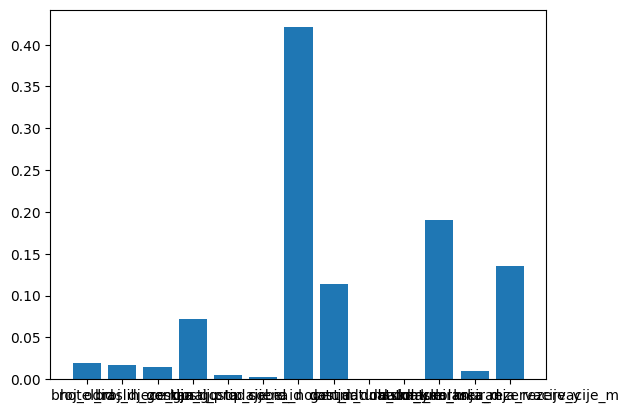

In [30]:
rfc = RandomForestRegressor(n_estimators=10, max_depth=10, max_features=7)

model.fit(X, Y)

importance = model.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (df_bookings.columns[i],v))

plt.bar([x for x in df_bookings.columns[:13]], importance)
plt.show()

In [31]:
rfc = LogisticRegression()

model.fit(X, Y)

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (df_bookings.columns[i],v))
# plot feature importance
plt.bar([x for x in df_bookings.columns[:13]], importance)
plt.show()

Feature: hotel_id, Score: 0.01723
Feature: broj_odraslih_gostiju, Score: 0.01350
Feature: broj_djece_gostiju, Score: 0.02358
Feature: zemlja_gosta, Score: 0.06634
Feature: kanal_prodaje_id, Score: 0.00728
Feature: tip_sobe_id, Score: 0.00916
Feature: cijena_nocenja, Score: 0.44261
Feature: gost_id, Score: 0.11359
Feature: datum_dolaska_y, Score: 0.00000
Feature: datum_dolaska_m, Score: 0.00000
Feature: datum_dolaska_d, Score: 0.18455
Feature: datum_kreiranja_rezervacije_y, Score: 0.00782
Feature: datum_kreiranja_rezervacije_m, Score: 0.11435


#### 4. Tasks

Task 1.

- Add GradientBoostingRegressor and Ridge regression to the comparison
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html


Task 2.
- Add new feature - week of the year
- Add new feature - weekend


Task 3.
- Add new feature - number of visits last week






#### 5. Ideas

1. Add new date-related features like day in the year, week of the year, ...
2. Aggregations - number of last week's visits, number of last months's visits, number of same week last year visits, ...
3. Time series algorithms (https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/) 
4. Try different scoring methods
5. Time based cross validation
- https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
- https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
